# PROYECTO FINAL SEÑALES III

---

**Juan Daniel Gonzalez puerta**

**Julian Andres Zapata Díaz**

**Santiago Sepulveda**

*Universidad de Antioquia*

2020

# CALIDAD DE AIRE EN LA CIUDAD DE MEDELLIN

# **PM2.5 partículas en el aire**


La calidad del aire en Medellín se ha convertido en los últimos10 años, uno de los aspectos más relevantes para las autoridades locales, con la implementación de un Plan de Descontaminación a mediano, largo y corto plazo para el manejo de episodios críticos del Valle de Aburrá, orientado a lograr cambios estructurales para la solución permanente de la contaminación atmosférica con todos los actores involucrados. 
Si bien la contaminación de aire está asociada con los porcentajes de emisión anual y 24 horas de contaminantes como óxidos de azufre (SOx), óxidos de  nitrógeno (NOx), ozono (O3), gas carbónico (CO2), material particulado respirables (PM10), material particulado de fracción fina (PM2.5) generados a nivel industrial y por el parque automotor para este trabajo se hara enfocado en PM2.5.

Las fuentes comunes de PM2.5 son:

*  humo de los incendios
*  humo de calentadores de madera
*  escapes de automóviles y camiones
*  Industria.


[PM2.5 particles in the air](https://repository.unimilitar.edu.co/bitstream/handle/10654/17019/G%C3%B3mezCombaCieloAmparo2017.pdf?sequence=1&isAllowed=y)


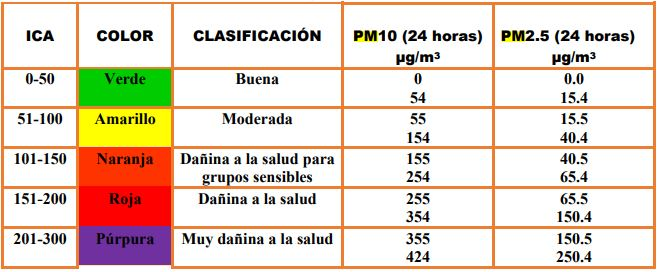

In [1]:
#Importamos librerias a usar
from google.colab import files

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd

import json
from pandas.io.json import json_normalize

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline



In [2]:
# librerias a instalar 
'''
!pip install sktime
!pip install geojson
!pip install geopandas
!pip install geojsonio
!pip install -U plotly
'''

'\n!pip install sktime\n!pip install geojson\n!pip install geopandas\n!pip install geojsonio\n!pip install -U plotly\n'

In [2]:
uploaded = files.upload() #comando para subir archivo

with open('Datos_SIATA_Aire_pm25_2018-2019.json') as f: #abrir archivo 
    dataset = json.load(f) #cargar base de datos

In [3]:
X = json_normalize(dataset,'datos',['nombre','latitud','longitud']) 
dataset = json_normalize(dataset) #normalizamos la base de datos
dataset.head(21) #mostramos la base de datos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,latitud,codigoSerial,datos,nombre,nombreCorto,longitud
0,6.379038,3,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",Girardota - S.O.S Aburrá Norte,GIR-SOSN,-75.450913
1,6.252561,12,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",Estación Tráfico Centro,CEN-TRAF,-75.569580
2,6.263370,25,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...","Medellín, centro occidente - Universidad Naci...",MED-UNNV,-75.577004
3,6.185667,28,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",Itagüí - Casa de Justicia Itagüí,ITA-CJUS,-75.597206
4,6.099081,31,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",Caldas - Corporacion Universitaria Lasallista,CAL-LASA,-75.638626
5,6.168497,38,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",Itagüí - I.E. Concejo Municipal de Itagüí,ITA-CONC,-75.644356
6,6.182542,44,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...","Medellín, El Poblado - Tanques La Ye EPM",MED-LAYE,-75.550636
7,6.152313,48,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",Estación Tráfico Sur,SUR-TRAF,-75.627487
8,6.093078,69,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",Caldas - E U Joaquín Aristizabal,CAL-JOAR,-75.637764
9,6.155531,78,"[{'variableConsulta': 'pm25', 'fecha': '2018-0...",La Estrella - Hospital,EST-HOSP,-75.644173


**Oservacion de la base de la base de datos:**

La base de datos cuenta 183981 datos recogidos a lo largo de un año y tiene 6 tipos de datos diferentes los cuales son:

*  longitud y latitud de las estaciones ubicadas en la region del area metropolitana.

*  codigo serial de cada estacion, aunque este codigo no representa nada importante y difieren de los codigos reales que aparece en la pagina del siata. se concluye que es un codigo para identificar cada estacion en la base de datos.

*  datos de las mediciones realizadas por la estacion, la variable consultada que en este caso es PM2.5, el valor medido y la fecha y hora de su analisis.

*  Nombre de la estacion y un nombre corto que la identidica.

Los datos se registraron desde agosto 28 del 2018 a las 04:00 am hasta agosto 28 del 2019 04:00 am con un periodo de una hora, por lo tanto 365 días por 24 horas por 21 estaciones tendriamos un total de 183.960 muestras.

In [4]:
# Desempaquetamos la Columna de datos  (unpack the Column datos)

X=X.drop(['variableConsulta', 'calidad'], axis=1)   # elimino columna que dice PM2.5 y la de calidad que parece que no tiene sentido.
X = X.values

# Consideraciones a tener en cuenta antes del analsis. 

Como se midio la cantidad de materia particulada en el aire de medellin no es factible valores no se consideran los valores negativos puesto que hay material particulado o no lo hay, por lo tanto si hay un valor negativo en la base de datos se asume como un error de sensado o que no hubo sensado por algún motivo, por lo cual se cambiaran por un valor igual a 1.0, debido a que como veremos más adleante algunos metodos necesitan que los valores sean estrictamente positivos.

Para conocer el valor maximo que estos sensores pueden haber detectado nos apoyaremos en la pagina del area metropolitana donde se almacenan todos los resumenes de la calidad de aire en medellin y los municipios del valle de aburra.

[Resumenes-calidad-del-aire](https://www.metropol.gov.co/ambiental/calidad-del-aire/Documents/Forms/AllItems.aspx?RootFolder=%2Fambiental%2Fcalidad%2Ddel%2Daire%2FDocuments%2FResumenes%2Dcalidad%2Ddel%2Daire&FolderCTID=0x0120008162DB5A0DE33D4FBDC4412520B8FAF8&View=%7B364E08F2%2DD1DE%2D4398%2DA5B2%2D6C0B0A6DE714%7D#InplviewHash364e08f2-d1de-4398-a5b2-6c0b0a6de714=RootFolder%3D%252fambiental%252fcalidad%252ddel%252daire%252fDocuments%252fResumenes%252dcalidad%252ddel%252daire)

Se reviso cuidadosamente 12 los resumenes mensuales y ademas el promedio anual entre 2018 a 2019 y se encontro que los valores de PM2.5 nunca superaban los 50ug/m^3 en promedio mensualmente, por esto es que se decidio que para valores mayores de 60.0 se igualarian al promedio que tuvo ese día el sensor.  

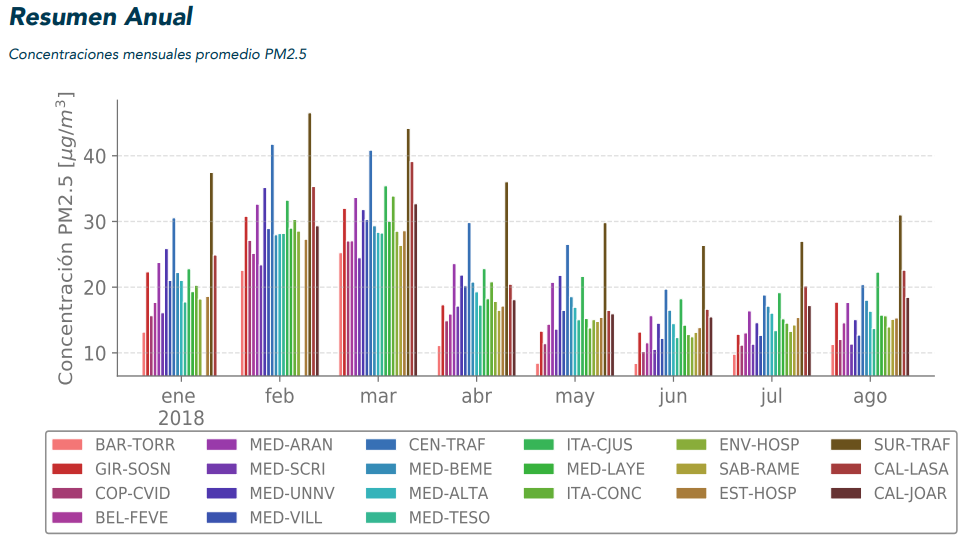


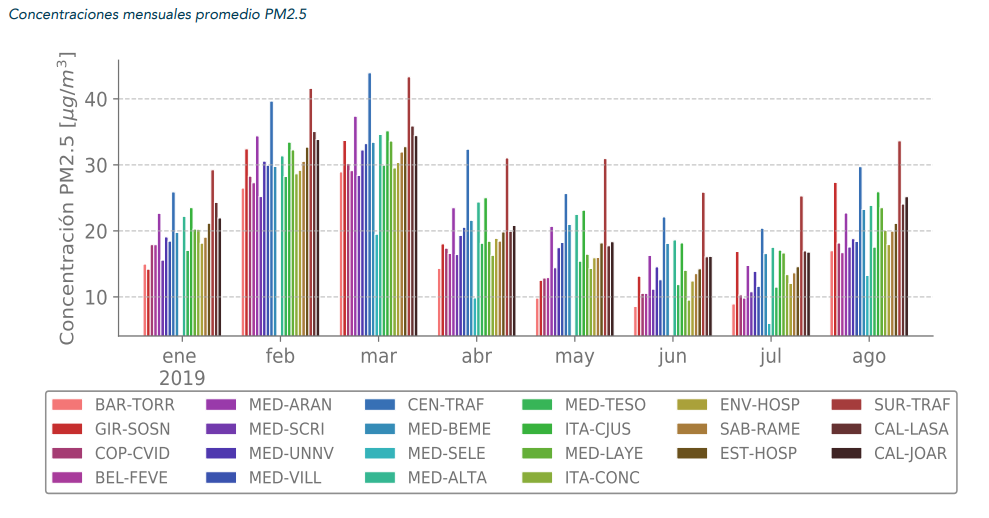

In [5]:
#ciclo que recorre toda la base de datos

for i in range(183981):
  if (X[i,1:2] > 150.0 or X[i,1:2] <= 0.0 ): #si el valor es mayor que 150.0
    X[i,1:2] = 160.0 #asignar 160.0 (como marca)


In [6]:
# ciclo que recorre todos los días de las 21 estaciones

# tomamos la cantidad de muestras y las dividimos entre los 24 días.

pro=0
for i in range (7665):
  aux=[] #variable auxiliar
  for h in range(24): #ciclo que recorre las 24 horas
    aux.append(X[24*i+h,1:2]) # agregar las 24 muestrar a la variable auxiliar

  m=0
  for j in range(24):
    if aux[j] != 160.0: # si hay un valor que no es un error.
      m=m+1
      pro=aux[j]+pro
  if m!=0: # si hubo al menos un valor que no era un error 
    pro=pro/m

  while 160.0 in aux: #mientras 160.0 este contenito en la variable auxiliar
    pos=aux.index(160.0) #guardo la posicion
    aux[pos]=0 # convierto el valor a 0
    X[pos+24*i,1:2] = pro # se reemplaza con el valor promedio del día

Con los datos medidos corregidos y listos para el analisis procedemos a graficar y revisar de manera general el comportamiento de la variable a los largo de un día o mes en una estación. 

para esto es utíl separar los datos por estacion, a cada estacion le corresponde un total de 8.760 muestras: 365 días X 24 horas.

In [7]:
# Separacion de los datos por estacion de medicion.
# Atencion los primeros 720 datos DE CADA itervalo corresponde al primer mes de cada estacion.

Xa = X[0:8761,:]          # 'Girardota - S.O.S Aburrá Norte'
Xb = X[8761:17522,:]      # 'Estación Tráfico Centro'
Xc = X[17522:26283,:]     # 'Medellín,  centro occidente - Universidad Nacional, sede El Volador'
Xd = X[26283:35044,:]     # 'Itagüí - Casa de Justicia Itagüí'
Xe = X[35044:43805,:]     # 'Caldas - Corporacion Universitaria Lasallista'
Xf = X[43805:52566,:]     # 'Itagüí - I.E. Concejo Municipal de Itagüí'
Xg = X[52566:61327,:]     # 'Medellín, El Poblado - Tanques La Ye EPM'
Xh = X[61327:70088,:]     # 'Estación Tráfico Sur'
Xi = X[70088:78849,:]     # 'Caldas - E U Joaquín Aristizabal'
Xj = X[78849:87610,:]     # 'La Estrella - Hospital'
Xk = X[87610:96371,:]     # 'Medellín, Altavista - I.E. Pedro Octavio Amado'
Xl = X[96371:105132,:]    # 'Medellín, Villahermosa - Planta de producción de agua potable EPM'
Xm = X[105132:113893,:]   # 'Barbosa - Torre Social'
Xn = X[113893:122654,:]   # 'Copacabana - Ciudadela Educativa La Vida'
Xo = X[122654:131415,:]   # 'Medellin, Belén - I.E Pedro Justo Berrio'
Xp = X[131415:140176,:]   # 'Medellín, El Poblado - I.E INEM sede Santa Catalina'
Xq = X[140176:148937,:]   # 'Medellín, San Cristobal - Parque Biblioteca Fernando Botero'
Xr = X[148937:157698,:]   # 'Medellín, Aranjuez - I.E Ciro Mendia'
Xs = X[157698:166459,:]   # 'Bello - I.E. Fernando Vélez'
Xt = X[166459:175220,:]   # 'Envigado - E.S.E. Santa Gertrudis'
Xu = X[175220:183981,:]   # 'Sabaneta - I.E. Rafael J. Mejía'

* Definimos una funcion que nos permita de manera interativa graficar el día o mes de una estacion en particualar.

In [8]:
# Funcion para dibujar la senal de DOS formas diferentes enviandole el mes, el dia y la estacion.

def plot_mes (Y, a, b):
  #a= float(a)
  b= int(b)
  ver = Y[720*a:720+720*a, :]
  c = 720  
  if (b > 0):
    ver = ver[24*b:24+24*b, :]
    c = 24

  plt.figure(figsize=(20,10))
  t=np.linspace(0, c, c)
  plt.plot(t,ver[:,1])
  plt.title('Material Particulado PM 2.5', pad = 20, fontdict={'fontsize':20, 'color': '#4873ab'})
  plt.xlabel('Horas')
  plt.ylabel('PM 2.5')
  plt.minorticks_on()
  plt.grid(b=True, which='minor')
  plt.grid()
  plt.show()

  import plotly.express as px

  ver = pd.DataFrame(ver)
  ver.columns =['Fecha', 'Q(Aire)', 'Sensor', 'latitud', 'longitud']
  fig = px.line(ver, x = 'Fecha', y = 'Q(Aire)')
  
  fig.show()
  

Para visualizar como se comporto el aire en una zona y un día en particular debemos seleccionar primero la estación, luego el mes y por ultimo el día.

Nota: si se desea revisar un mes completo debe seleccionar en dia_selec cero (0).

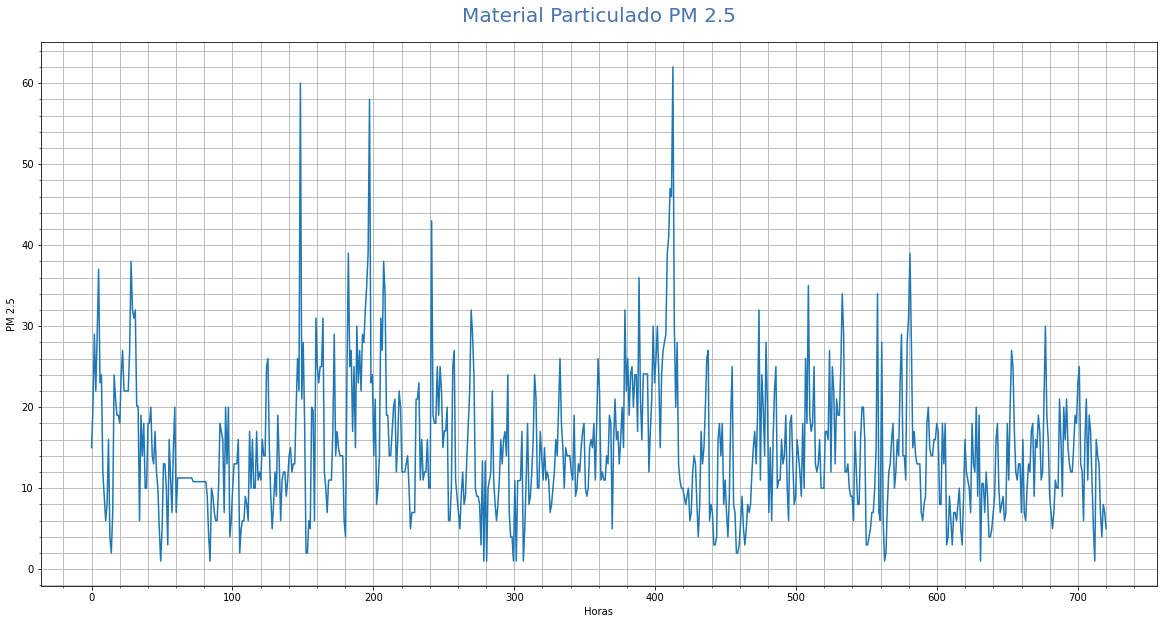

In [13]:
# Si en dia_selec se escoge 0 (ZERO) se plotea todo el mes.

meses_dic = {'Septiembre(2018)' : 0, 'Octubre(2018)' : 1, 'Noviembre(2018)' : 2, 'Diciembre(2018)' : 3, 'Enero(2019)' : 4, 'Febrero(2019)' : 5, 'Marzo(2019)' : 6, 
         'Abril(2019)' : 7, 'Mayo(2019)' : 8, 'junio(2019)' : 9, 'Julio(2019)' : 10, 'Agosto(2019)' : 11}
estacion_dic = {'Girardota - S.O.S Aburra Norte' : Xa, 'Estacion Trafico Centro' : Xb, 'Medellin,  centro occidente - Universidad Nacional, sede El Volador' : Xc,
             'Itagui - Casa de Justicia Itagui' : Xd, 'Caldas - Corporacion Universitaria Lasallista' : Xe, 'Itagui - I.E. Concejo Municipal de Itagui' : Xf,
             'Medellin, El Poblado - Tanques La Ye EPM' : Xg, 'Estacion Trafico Sur' : Xh, 'Caldas - E U Joaquin Aristizabal' : Xi,
             'La Estrella - Hospital' : Xj, 'Medellin, Altavista - I.E. Pedro Octavio Amado' : Xk, 'Medellin, Villahermosa - Planta de produccion de agua potable EPM' : Xl,
             'Barbosa - Torre Social' : Xm, 'Copacabana - Ciudadela Educativa La Vida' : Xn, 'Medellin, Belen - I.E Pedro Justo Berrio' : Xo, 
             'Medellin, El Poblado - I.E INEM sede Santa Catalina' : Xp, 'Medellin, San Cristobal - Parque Biblioteca Fernando Botero' : Xq,
             'Medellin, Aranjuez - I.E Ciro Mendia' : Xr, 'Bello - I.E. Fernando Velez' : Xs, 'Envigado - E.S.E. Santa Gertrudis' : Xt, 
             'Sabaneta - I.E. Rafael J. Mejia' : Xu}

estacion_selec = 'Girardota - S.O.S Aburra Norte'  # @param ['Girardota - S.O.S Aburra Norte', 'Estacion Trafico Centro', 'Medellin,  centro occidente - Universidad Nacional, sede El Volador', 'Itagui - Casa de Justicia Itagui', 'Caldas - Corporacion Universitaria Lasallista', 'Itagui - I.E. Concejo Municipal de Itagui', 'Medellin, El Poblado - Tanques La Ye EPM', 'Estacion Trafico Sur', 'Caldas - E U Joaquin Aristizabal', 'La Estrella - Hospital', 'Medellin, Altavista - I.E. Pedro Octavio Amado', 'Medellin, Villahermosa - Planta de produccion de agua potable EPM', 'Barbosa - Torre Social', 'Copacabana - Ciudadela Educativa La Vida', 'Medellin, Belen - I.E Pedro Justo Berrio', 'Medellin, El Poblado - I.E INEM sede Santa Catalina', 'Medellin, San Cristobal - Parque Biblioteca Fernando Botero', 'Medellin, Aranjuez - I.E Ciro Mendia', 'Bello - I.E. Fernando Velez', 'Envigado - E.S.E. Santa Gertrudis', 'Sabaneta - I.E. Rafael J. Mejía']
mes_selec = 'Septiembre(2018)'  # @param ['Septiembre(2018)', 'Octubre(2018)', 'Noviembre(2018)', 'Diciembre(2018)', 'Enero(2019)', 'Febrero(2019)', 'Marzo(2019)', 'Abril(2019)', 'Mayo(2019)', 'junio(2019)', 'Julio(2019)', 'Agosto(2019)']
dia_selec = "0"  # @param [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]


plot_mes((estacion_dic[estacion_selec]), meses_dic[mes_selec], dia_selec)



## Caracteristicas

*  Energia
*  Promedio
*  Desviacion estandar

In [14]:
# creo una lista con los nombre de las estaciones
nom_estaciones=['Girardota - S.O.S Aburra Norte', 'Estacion Trafico Centro', 'Medellin,  centro occidente - Universidad Nacional, sede El Volador',
             'Itagui - Casa de Justicia Itagui', 'Caldas - Corporacion Universitaria Lasallista', 'Itagui - I.E. Concejo Municipal de Itagui',
             'Medellin, El Poblado - Tanques La Ye EPM', 'Estacion Trafico Sur', 'Caldas - E U Joaquin Aristizabal',
             'La Estrella - Hospital', 'Medellin, Altavista - I.E. Pedro Octavio Amado', 'Medellin, Villahermosa - Planta de produccion de agua potable EPM',
             'Barbosa - Torre Social', 'Copacabana - Ciudadela Educativa La Vida', 'Medellin, Belen - I.E Pedro Justo Berrio', 
             'Medellin, El Poblado - I.E INEM sede Santa Catalina', 'Medellin, San Cristobal - Parque Biblioteca Fernando Botero',
             'Medellin, Aranjuez - I.E Ciro Mendia', 'Bello - I.E. Fernando Velez', 'Envigado - E.S.E. Santa Gertrudis', 
             'Sabaneta - I.E. Rafael J. Mejia']

X = pd.DataFrame(X)
X.columns =['Fecha', 'Q(Aire)', 'Sensor', 'latitud', 'longitud']

# extraigo los valores de las estaciones
Valores=X['Q(Aire)']

# paso los valores guardados en una seria a una lista
valor=Valores.tolist()

# separo los valores por estaciones
va = valor[0:8761]         # 'Girardota - S.O.S Aburrá Norte'
vb = valor[8761:17522]     # 'Estación Tráfico Centro'
vc = valor[17522:26283]     # 'Medellín,  centro occidente - Universidad Nacional, sede El Volador'
vd = valor[26283:35044]     # 'Itagüí - Casa de Justicia Itagüí'
ve = valor[35044:43805]     # 'Caldas - Corporacion Universitaria Lasallista'
vf = valor[43805:52566]     # 'Itagüí - I.E. Concejo Municipal de Itagüí'
vg = valor[52566:61327]     # 'Medellín, El Poblado - Tanques La Ye EPM'
vh = valor[61327:70088]     # 'Estación Tráfico Sur'
vi = valor[70088:78849]     # 'Caldas - E U Joaquín Aristizabal'
vj = valor[78849:87610]     # 'La Estrella - Hospital'
vk = valor[87610:96371]     # 'Medellín, Altavista - I.E. Pedro Octavio Amado'
vl = valor[96371:105132]    # 'Medellín, Villahermosa - Planta de producción de agua potable EPM'
vm = valor[105132:113893]   # 'Barbosa - Torre Social'
vn = valor[113893:122654]   # 'Copacabana - Ciudadela Educativa La Vida'
vo = valor[122654:131415]   # 'Medellin, Belén - I.E Pedro Justo Berrio'
vp = valor[131415:140176]   # 'Medellín, El Poblado - I.E INEM sede Santa Catalina'
vq = valor[140176:148937]   # 'Medellín, San Cristobal - Parque Biblioteca Fernando Botero'
vr = valor[148937:157698]   # 'Medellín, Aranjuez - I.E Ciro Mendia'
vs = valor[157698:166459]   # 'Bello - I.E. Fernando Vélez'
vt = valor[166459:175220]   # 'Envigado - E.S.E. Santa Gertrudis'
vu = valor[175220:183981]   # 'Sabaneta - I.E. Rafael J. Mejía'

Fechas = X['Fecha']

fecha = Fechas.to_list()

fa = fecha[0:8761]         # 'Girardota - S.O.S Aburrá Norte'
fb = fecha[8761:17522]     # 'Estación Tráfico Centro'
fc = fecha[17522:26283]     # 'Medellín,  centro occidente - Universidad Nacional, sede El Volador'
fd = fecha[26283:35044]     # 'Itagüí - Casa de Justicia Itagüí'
fe = fecha[35044:43805]     # 'Caldas - Corporacion Universitaria Lasallista'
ff = fecha[43805:52566]     # 'Itagüí - I.E. Concejo Municipal de Itagüí'
fg = fecha[52566:61327]     # 'Medellín, El Poblado - Tanques La Ye EPM'
fh = fecha[61327:70088]     # 'Estación Tráfico Sur'
fi = fecha[70088:78849]     # 'Caldas - E U Joaquín Aristizabal'
fj = fecha[78849:87610]     # 'La Estrella - Hospital'
fk = fecha[87610:96371]     # 'Medellín, Altavista - I.E. Pedro Octavio Amado'
fl = fecha[96371:105132]    # 'Medellín, Villahermosa - Planta de producción de agua potable EPM'
fm = fecha[105132:113893]   # 'Barbosa - Torre Social'
fn = fecha[113893:122654]   # 'Copacabana - Ciudadela Educativa La Vida'
fo = fecha[122654:131415]   # 'Medellin, Belén - I.E Pedro Justo Berrio'
fp = fecha[131415:140176]   # 'Medellín, El Poblado - I.E INEM sede Santa Catalina'
fq = fecha[140176:148937]   # 'Medellín, San Cristobal - Parque Biblioteca Fernando Botero'
fr = fecha[148937:157698]   # 'Medellín, Aranjuez - I.E Ciro Mendia'
fs = fecha[157698:166459]   # 'Bello - I.E. Fernando Vélez'
ft = fecha[166459:175220]   # 'Envigado - E.S.E. Santa Gertrudis'
fu = fecha[175220:183981]   # 'Sabaneta - I.E. Rafael J. Mejía'

In [15]:
estaciones = [va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu]

print('cantidad de estaciones: '+str(len(estaciones)))


cantidad de estaciones: 21


# **Energia**

Energia:
0- 34597.502052419644 estacion: Girardota - S.O.S Aburra Norte
1- 69987.22829871404 estacion: Estacion Trafico Centro
2- 33832.52478842247 estacion: Medellin,  centro occidente - Universidad Nacional, sede El Volador
3- 50181.6588085764 estacion: Itagui - Casa de Justicia Itagui
4- 45101.10019866021 estacion: Caldas - Corporacion Universitaria Lasallista
5- 31782.977738079993 estacion: Itagui - I.E. Concejo Municipal de Itagui
6- 40272.991110945215 estacion: Medellin, El Poblado - Tanques La Ye EPM
7- 84573.18711491383 estacion: Estacion Trafico Sur
8- 40685.40955783402 estacion: Caldas - E U Joaquin Aristizabal
9- 36849.46826469765 estacion: La Estrella - Hospital
10- 43568.974981622916 estacion: Medellin, Altavista - I.E. Pedro Octavio Amado
11- 34594.30508997576 estacion: Medellin, Villahermosa - Planta de produccion de agua potable EPM
12- 20414.876399604436 estacion: Barbosa - Torre Social
13- 26311.433368111262 estacion: Copacabana - Ciudadela Educativa La Vida
14- 44641

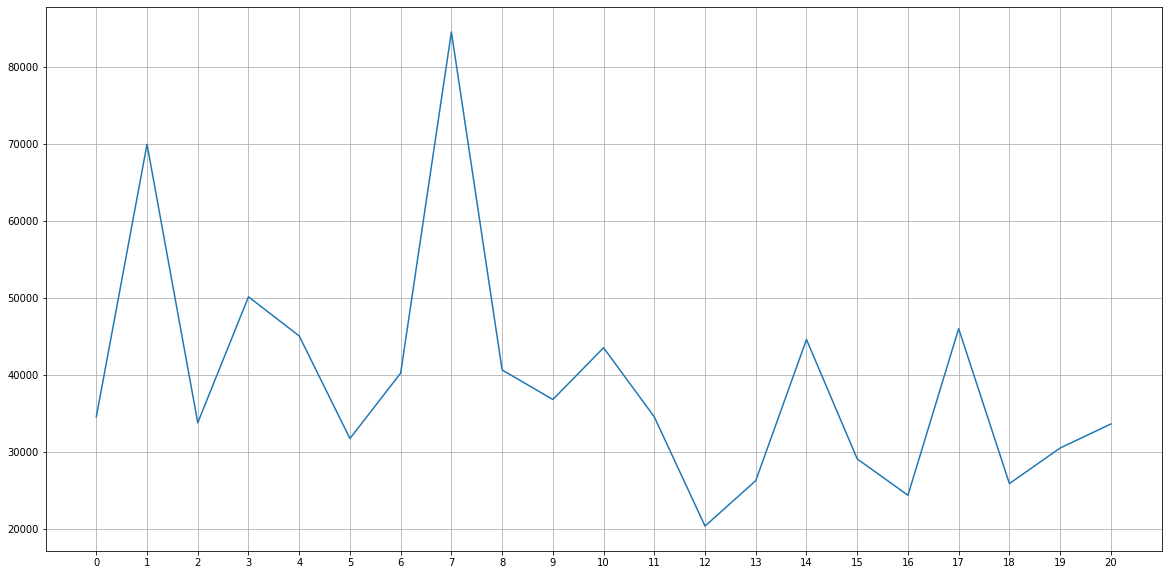

In [16]:
import scipy.integrate as integrate
energia_señal=[]

for i in range (21):
  señal = estaciones[i] #señal
  ts = len(señal)/128. #tiempo de muestreo
  time = np.linspace(0,ts,len(señal)) #tiemppo
  cuadrado=[]
  for i in range(0,len(señal)):
	  cuadrado.append(señal[i]*señal[i])
  energia = integrate.simps(cuadrado,time)#calculo la energia
  energia_señal.append(energia)

print('Energia:')
for i in range(21):
  print(str(i)+'- '+str(energia_señal[i])+' estacion: '+nom_estaciones[i])

plt.figure(figsize=(20,10))
plt.plot(energia_señal)
plt.xticks(np.arange(0, 21, step=1))
plt.grid()
plt.show()

* Estaciones más altas: 1, y 7.

* Estaciones más bajas: 12, 13, 16, 18 y 19.

# **Promedio**


Promedio:
0- 18.507370901790495 estacion: Girardota - S.O.S Aburra Norte
1- 28.147130022320173 estacion: Estacion Trafico Centro
2- 19.520535951311434 estacion: Medellin,  centro occidente - Universidad Nacional, sede El Volador
3- 24.02646359919185 estacion: Itagui - Casa de Justicia Itagui
4- 22.400038757220543 estacion: Caldas - Corporacion Universitaria Lasallista
5- 18.629530928420586 estacion: Itagui - I.E. Concejo Municipal de Itagui
6- 20.462247452227544 estacion: Medellin, El Poblado - Tanques La Ye EPM
7- 31.715800277737983 estacion: Estacion Trafico Sur
8- 21.460033198937843 estacion: Caldas - E U Joaquin Aristizabal
9- 20.52561143894049 estacion: La Estrella - Hospital
10- 22.505923463071206 estacion: Medellin, Altavista - I.E. Pedro Octavio Amado
11- 19.311721509052393 estacion: Medellin, Villahermosa - Planta de produccion de agua potable EPM
12- 13.912329720234242 estacion: Barbosa - Torre Social
13- 16.644819775295137 estacion: Copacabana - Ciudadela Educativa La Vida
1

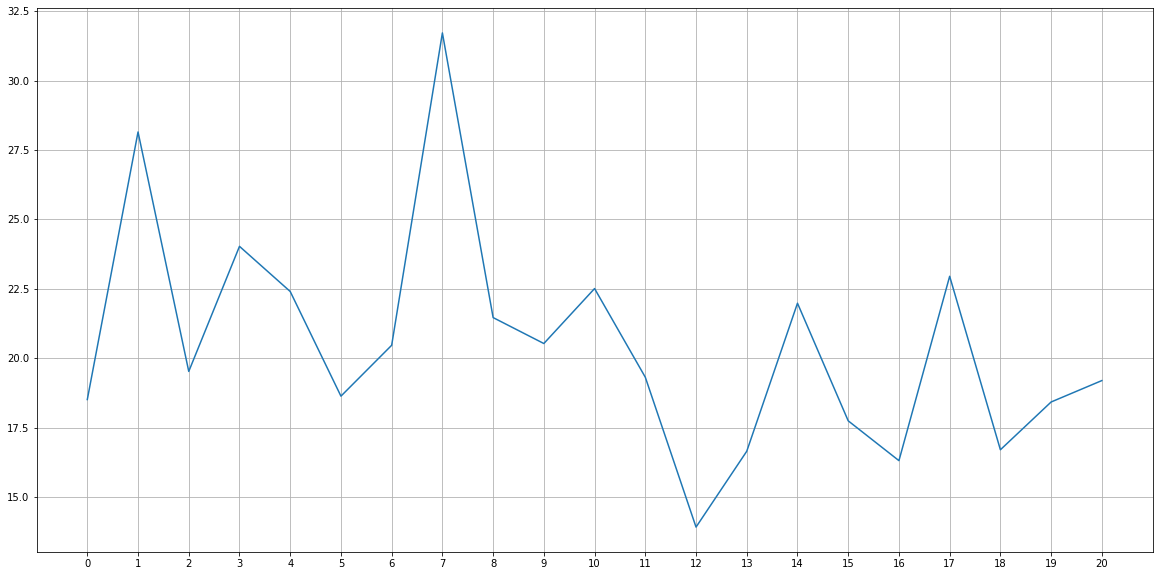

In [17]:
promedio_señal=[] #lista para guardar los promedios 

for i in range(21): #ciclo que recorre todos las estaciones
  señal = estaciones[i] 
  promedio_señal.append(np.mean(señal))# calculo del promedio de la señal

print('Promedio:')
for i in range(21):
  print(str(i)+'- '+str(promedio_señal[i])+' estacion: '+nom_estaciones[i])

plt.figure(figsize=(20,10))
plt.plot(promedio_señal)
plt.xticks(np.arange(0, 21, step=1))
plt.grid()
plt.show()

* Estaciones más altas: 1 y 7.

* Estaciones más bajas: 12, 16 y 18.

# **Desviacion estandar**

Desviacion estandar:
0- 12.79956300432432 estacion: Girardota - S.O.S Aburra Norte
1- 15.17347945479725 estacion: Estacion Trafico Centro
2- 10.619606278200735 estacion: Medellin,  centro occidente - Universidad Nacional, sede El Volador
3- 12.490942298306194 estacion: Itagui - Casa de Justicia Itagui
4- 12.522667313418877 estacion: Caldas - Corporacion Universitaria Lasallista
5- 10.795993695467905 estacion: Itagui - I.E. Concejo Municipal de Itagui
6- 12.973512478359508 estacion: Medellin, El Poblado - Tanques La Ye EPM
7- 15.198978179261113 estacion: Estacion Trafico Sur
8- 11.542045940494953 estacion: Caldas - E U Joaquin Aristizabal
9- 10.887187036044411 estacion: La Estrella - Hospital
10- 11.466127387445283 estacion: Medellin, Altavista - I.E. Pedro Octavio Amado
11- 11.522616067338463 estacion: Medellin, Villahermosa - Planta de produccion de agua potable EPM
12- 10.238311281233509 estacion: Barbosa - Torre Social
13- 10.33447806832186 estacion: Copacabana - Ciudadela Educativa

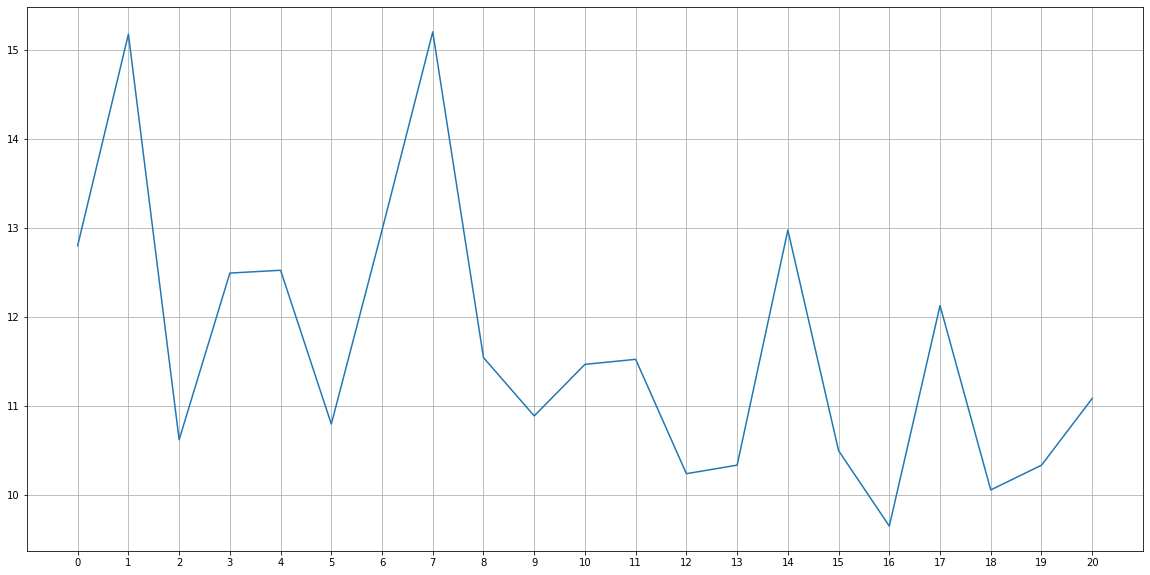

In [18]:
std_señal=[] #lista para guardar los promedios 

for i in range(21): #ciclo que recorre todos las estaciones
  señal = estaciones[i] 
  std_señal.append(np.std(señal))# calculo del promedio de la señal

print('Desviacion estandar:')
for i in range(21):
  print(str(i)+'- '+str(std_señal[i])+' estacion: '+nom_estaciones[i])

plt.figure(figsize=(20,10))
plt.plot(std_señal)
plt.xticks(np.arange(0, 21, step=1))
plt.grid()
plt.show()

* Estaciones más altas: 1, 2 y 7.

* Estaciones más bajas: 10, 12, 13, 16, 18 y 19.

# **Discusion:**

vemos que generalmente las más altas fueron siempre las estaciones 1 y 7 (Estacion Trafico Centro y Estacion Trafico Sur), lo cual tiene sentido ya que son zonas muy elevadas para el trafico, ademas de que estan muy centradas en la ciudad, tambien puede ser a que hay varias empresas y/o fabricas cercas las cuales liberan muchas de estas particulas contaminantes entre otras.

por otro lado las más bajas en general son 12, 13, 16, 18 y 19 (Barbosa - Torre Social, Copacabana - Ciudadela Educativa La Vida, Medellin, San Cristobal - Parque Biblioteca Fernando Boter, Bello - I.E. Fernando Velez y Envigado - E.S.E. Santa Gertrudis) que si observamos son las que suelen ser las zonas más rurales y menos congestionadas por empresas y por automoviles. 

# **SKTIME** 



In [19]:
#librerias necesarias para la prediccion

from warnings import simplefilter

from sktime.forecasting.base import ForecastingHorizon

from sktime.forecasting.naive import NaiveForecaster

from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.theta import ThetaForecaster

from sktime.forecasting.ets import AutoETS

from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline


# prediccion sobre un mes.
Vamos a realziar la predicion sobre un mes, para esto tomamos una esatcion en particular y la cortamos dejando 720 muestras, ya que se toma una muestra cada hora: 24*30=720 



### **Para cuantificar la calidad de la prediccion vamos a calcular el Smape**.

El error de porcentaje absoluto medio simétrico (SMAPE o sMAPE) es una medida de precisión basada en errores porcentuales (o relativos). Por lo general se define de la siguiente manera:

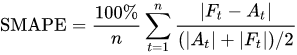

donde At es el valor real y Ft es el valor de previsión.

La diferencia absoluta entre At y Ft se divide por la mitad de la suma de los valores absolutos del valor real At y el valor de previsión Ft. El valor de este cálculo se suma para cada punto ajustado t y se divide de nuevo por el número de puntos ajustados n.

Python tiene la funcion implemntada con la libreria  Sktime

nosotros usaremos el metodo smape_loss el cual no dará el error de la prevision, a menor sea este numero mejor sera la prediccion


Text(0.5, 1.0, 'Estacion: Girardota - S.O.S Aburra Norte Mes: Septiembre(2018)')

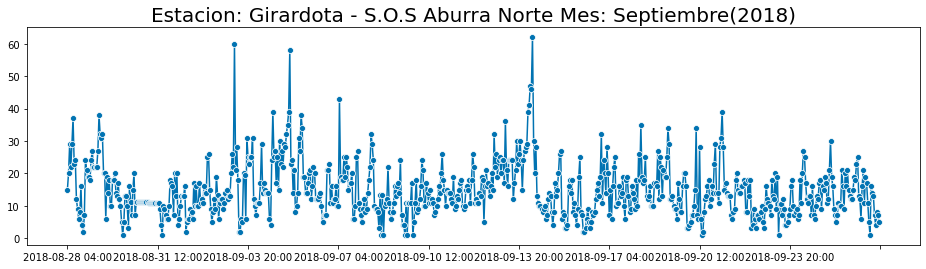

In [21]:
#hay que hacer las series o señales para cada una de las estaciones, para que haya congruencia con las fechas 

# extraemos los valores y las fechas 
estaciones_diccionario = {'Girardota - S.O.S Aburra Norte' : va, 'Estacion Trafico Centro' : vb, 'Medellin,  centro occidente - Universidad Nacional, sede El Volador' : vc, 'Itagui - Casa de Justicia Itagui' : vd, 'Caldas - Corporacion Universitaria Lasallista' : ve, 'Itagui - I.E. Concejo Municipal de Itagui' : vf, 'Medellin, El Poblado - Tanques La Ye EPM' : vg, 'Estacion Trafico Sur' : vh, 'Caldas - E U Joaquin Aristizabal' : vi, 'La Estrella - Hospital' : vj, 'Medellin, Altavista - I.E. Pedro Octavio Amado' : vk, 'Medellin, Villahermosa - Planta de produccion de agua potable EPM' : vl, 'Barbosa - Torre Social' : vm, 'Copacabana - Ciudadela Educativa La Vida' : vn, 'Medellin, Belen - I.E Pedro Justo Berrio' : vo, 'Medellin, El Poblado - I.E INEM sede Santa Catalina' : vp, 'Medellin, San Cristobal - Parque Biblioteca Fernando Botero' : vq, 'Medellin, Aranjuez - I.E Ciro Mendia' : vr, 'Bello - I.E. Fernando Velez' : vs, 'Envigado - E.S.E. Santa Gertrudis' : vt, 'Sabaneta - I.E. Rafael J. Mejia' : vu}

estación = 'Girardota - S.O.S Aburra Norte'  # @param ['Girardota - S.O.S Aburra Norte', 'Estacion Trafico Centro', 'Medellin,  centro occidente - Universidad Nacional, sede El Volador', 'Itagui - Casa de Justicia Itagui', 'Caldas - Corporacion Universitaria Lasallista', 'Itagui - I.E. Concejo Municipal de Itagui', 'Medellin, El Poblado - Tanques La Ye EPM', 'Estacion Trafico Sur', 'Caldas - E U Joaquin Aristizabal', 'La Estrella - Hospital', 'Medellin, Altavista - I.E. Pedro Octavio Amado', 'Medellin, Villahermosa - Planta de produccion de agua potable EPM', 'Barbosa - Torre Social', 'Copacabana - Ciudadela Educativa La Vida', 'Medellin, Belen - I.E Pedro Justo Berrio', 'Medellin, El Poblado - I.E INEM sede Santa Catalina', 'Medellin, San Cristobal - Parque Biblioteca Fernando Botero', 'Medellin, Aranjuez - I.E Ciro Mendia', 'Bello - I.E. Fernando Velez', 'Envigado - E.S.E. Santa Gertrudis', 'Sabaneta - I.E. Rafael J. Mejía']

e = estaciones_diccionario[estación]

mes= 'Septiembre(2018)'  # @param ['Septiembre(2018)', 'Octubre(2018)', 'Noviembre(2018)', 'Diciembre(2018)', 'Enero(2019)', 'Febrero(2019)', 'Marzo(2019)', 'Abril(2019)', 'Mayo(2019)', 'junio(2019)', 'Julio(2019)', 'Agosto(2019)']

m = meses_dic[mes]

Za=pd.Series(e[720*m:720*m+720],fa[720*m:720*m+720])

# como tenemos el tiempo incrementando en horas ponemos la frecuencia del Periodindex "H".

Za.index = pd.PeriodIndex(Za.index, freq="H", name="Period")

# graficamos el mes a predecir

plot_series(Za);
plt.title('Estacion: '+estación+' Mes: '+mes, fontdict={'fontsize':20})



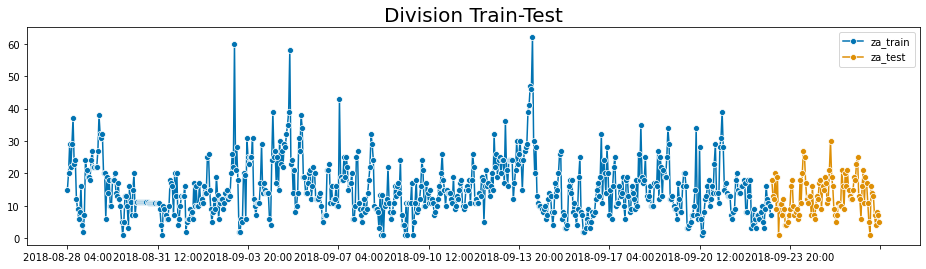

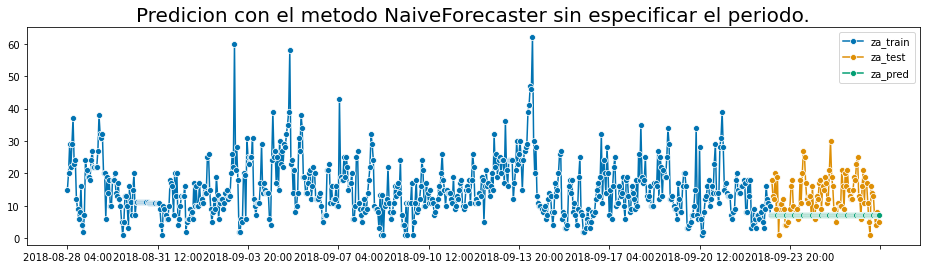

smape: 0.5816152346799583



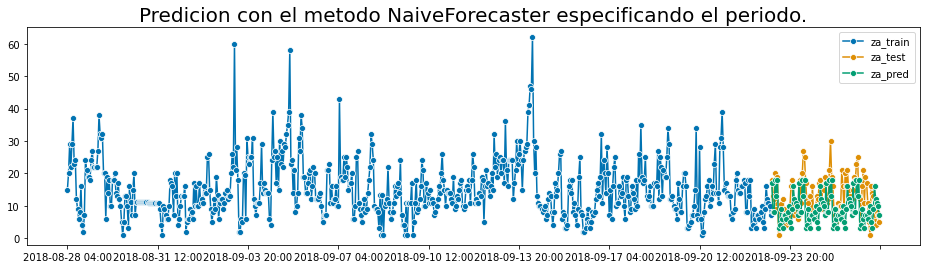

smape: 0.5591967469365958



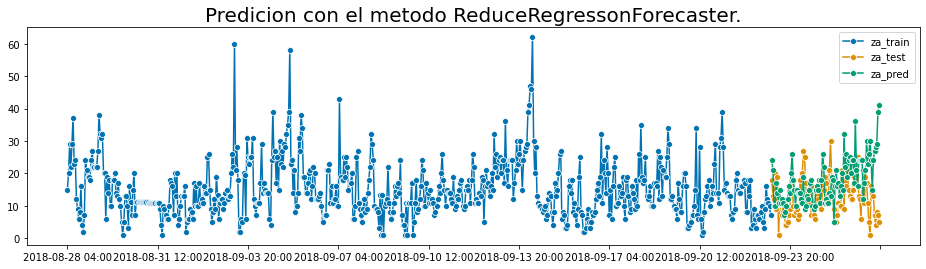

smape: 0.5245279761270376

smape: 0.4236245050489044



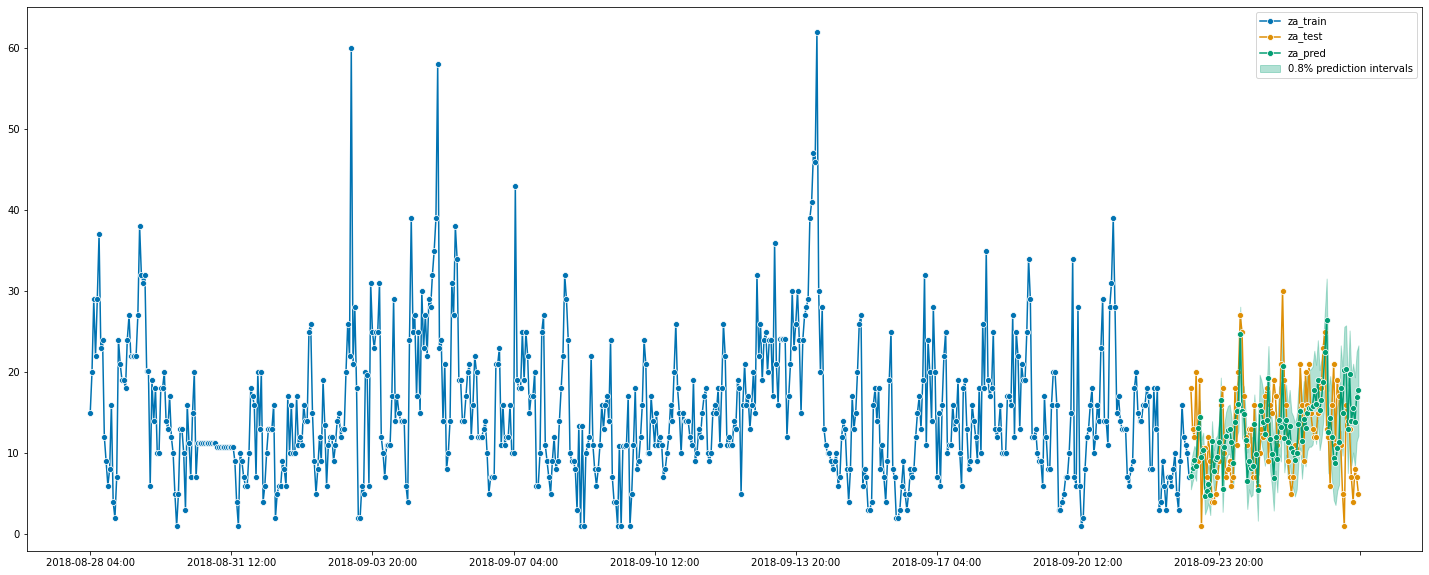

In [22]:
# vamos a predeccir sobre de 1 a 7 días sobre un mes. 

Pre_dias= "4"  # @param [1,2,3,4,5,6,7]

p=int(Pre_dias)*24

za_train, za_test = temporal_train_test_split(Za, test_size=p)
plot_series(za_train, za_test, labels=["za_train", "za_test"])
plt.title('Division Train-Test', fontdict={'fontsize':20})
plt.show()
print("")

# creamos el horizonte de pronostico 
fh = ForecastingHorizon(za_test.index, is_relative=False)

# metodo NaiveForecaster sin periodo estacional
forecaster = NaiveForecaster(strategy="last") # primero creamos el modelo sin especificar la periocida estacional
forecaster.fit(za_train) #entrenamos el modelo
za_pred = forecaster.predict(fh) # predecimos 
plot_series(za_train, za_test, za_pred, labels=["za_train", "za_test", "za_pred"]) # graficamos
plt.title('Predicion con el metodo NaiveForecaster sin especificar el periodo.', fontdict={'fontsize':20})
plt.show()
print('smape: '+str(smape_loss(za_pred, za_test)))
print("")

# metodo NaiveForecaster con periodo estacional
forecaster = NaiveForecaster(strategy="last", sp=24)
forecaster.fit(za_train)
za_pred = forecaster.predict(fh)
plot_series(za_train, za_test, za_pred, labels=["za_train", "za_test", "za_pred"])
plt.title('Predicion con el metodo NaiveForecaster especificando el periodo.', fontdict={'fontsize':20})
plt.show()
print('smape: '+str(smape_loss(za_pred, za_test)))
print("")


# metodo metodo ReduceRegressonForecaster
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=24, strategy='recursive'
)
forecaster.fit(za_train)
za_pred = forecaster.predict(fh)
plot_series(za_train, za_test, za_pred, labels=["za_train", "za_test", "za_pred"])
plt.title('Predicion con el metodo ReduceRegressonForecaster.', fontdict={'fontsize':20})
plt.show()
print('smape: '+str(smape_loss(za_pred, za_test)))
print("")

forecaster = ThetaForecaster(sp=168)
forecaster.fit(za_train)
alpha = 0.80  # 95% prediction intervals
za_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)

fig, ax = plot_series(za_train, za_test, za_pred, labels=["za_train", "za_test", "za_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.3,
    color=ax.get_lines()[-1].get_c(),
    label=f"{alpha}% prediction intervals",
)
ax.legend();
fig.set_size_inches(25,10)

print('smape: '+str(smape_loss(za_pred, za_test)))
print("")


* Vemos que sin ajustar el periodo estacional tenemos una predicion bastate mala, se aprecia grafiamnete que la prediccion es cercana al promedio y es un valor constante, cuantitativamente tenemos un smape de 0.5 lo cual si bien no es alto se debe a que matematicamte siempre se esta restando y dividiendo sobre el promedio absoluto.

* Vemos que la prediccion mejora bastante graficamente y como se puede apreciar tambien bajo el smape aunque no mucho.

## Acercamiento al uso de mapas 

In [ ]:
import geojson
import geopandas as gpd
import geojsonio

In [ ]:
# Area_Met_01.geojson mapa del area metropolitana separada por municipios.

uploaded = files.upload()

states = gpd.read_file('Area_Met_01.geojson')
states.head()

In [ ]:
states.columns

In [ ]:
#geojsonio.display(states) # Requires authentication????

In [ ]:
states

In [ ]:
#states['STATION'] = X[]
X = pd.DataFrame(X)
X.columns =['Fecha', 'Q(Aire)', 'Sensor', 'latitud', 'longitud']
X1 = gpd.GeoDataFrame(X)
states['Sensor'] = [100,63,26,115,21,87,94,80,102,124]   # Esto para ejemplo evaluacion
states
X1

In [ ]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Área Metropolitana del Valle de Aburrá', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Añadir la leyenda separada del mapa
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Mostrar el mapa finalizado
#states.plot(column='Sensor', cmap='plasma', ax=ax, zorder=5)
states.plot(column='MPIO_CCDGO', cmap='plasma', ax=ax, # cmap='plasma'
              legend=True, cax=cax, zorder=5)

In [ ]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
 
# Control del encuadre (área geográfica) del mapa
#ax.axis([-12, 5, 32, 48])
 
# Control del título y los ejes
ax.set_title('Área Metropolitana del Valle de Aburrá', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Añadir la leyenda separada del mapa
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
 
# Generar y cargar el mapa
states.plot(column='MPIO_CCDGO', cmap='summer', ax=ax, # cmap='plasma'
              legend=True, cax=cax, zorder=5)

In [ ]:
!pip install -U plotly

In [ ]:
import plotly.express as px
fig = px.line(states, x= 'MPIO_CNMBR', y = 'Sensor')
fig.show()